# Text classification with Keras

## 1. Load libraries

In [1]:
import pandas as pd
pd.options.display.max_columns = 200
pd.options.mode.chained_assignment = None

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
from string import punctuation

from collections import Counter
import re
import numpy as np
import seaborn as sns

from wordcloud import WordCloud

import pickle

from tqdm import tqdm_notebook
# tqdm_notebook().pandas()
from tqdm import tqdm
from matplotlib import pyplot as plt
import re
from functools import reduce

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.model_selection import (train_test_split, KFold, StratifiedKFold,
                                     cross_val_score, GridSearchCV,
                                     learning_curve, validation_curve)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (log_loss, accuracy_score, f1_score,
                             classification_report, confusion_matrix,
                             recall_score, roc_auc_score)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                              ExtraTreesClassifier, GradientBoostingClassifier)
from xgboost import XGBClassifier

from nltk.tokenize import WordPunctTokenizer, word_tokenize, sent_tokenize
from bs4 import BeautifulSoup
import unicodedata
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from nlp_func import *

In [4]:
from modelling_pipeline import pipeline_nlp

In [234]:
from plots_ import plot_history

## 2. Create some functions

In [5]:
# Stopwords tokens
stopwords_en = set(stopwords.words('english'))
stopwords_en_json = pd.read_json("./stop_words_en.json")
new_stop = ['t', 'will']

In [6]:
stopwords_punct = set(punctuation)
stoplist_combined = set.union(stopwords_punct, stopwords_en, stopwords_en_json, new_stop)

my_list = list(stoplist_combined)

|WordNet tag   |Treebank tag   |
|---|---|
| n  | NN  |
|  a | JJ  |
|  s | JJ  |
|  r |  RB |
|  v |  VB |

## 3. Load data

In [7]:
filepath_dict = {
    'yelp': 'data/yelp_labelled.txt',
    'amazon': 'data/amazon_cells_labelled.txt',
    'imdb': 'data/imdb_labelled.txt'
}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source
    df_list.append(df)

df = pd.concat(df_list)
print(df.iloc[0])

sentence    Wow... Loved this place.
label                              1
source                          yelp
Name: 0, dtype: object


## 3. Data analysis

Below I'll have a look at the frist 5 columns of the data:

In [8]:
df.head()

,sentence,label,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp


In [9]:
df.shape

(2748, 3)

The data has 2748 rows and 3 columns

Now let's have a look at the distribution of the sentences in each source:

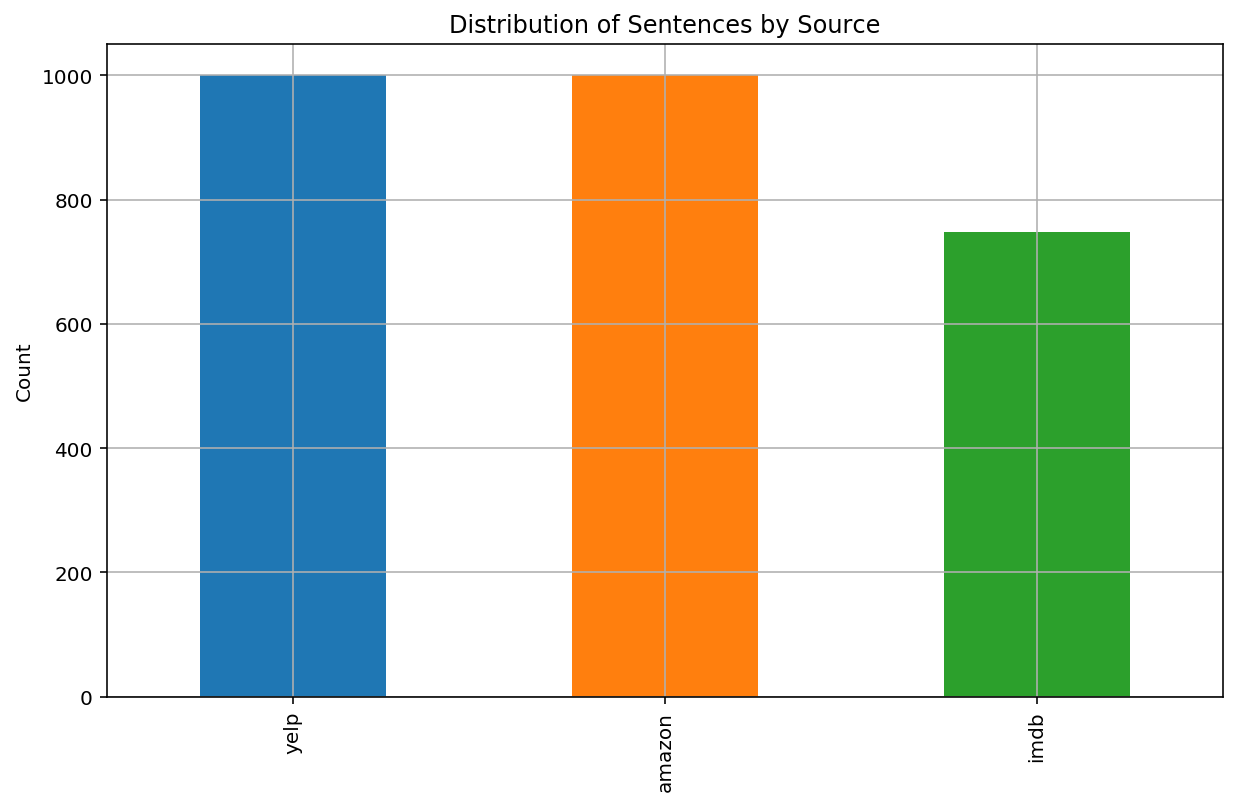

In [10]:
df.source.value_counts().plot(kind='bar', grid=True, figsize=(10, 6))
plt.title("Distribution of Sentences by Source")
plt.ylabel('Count')

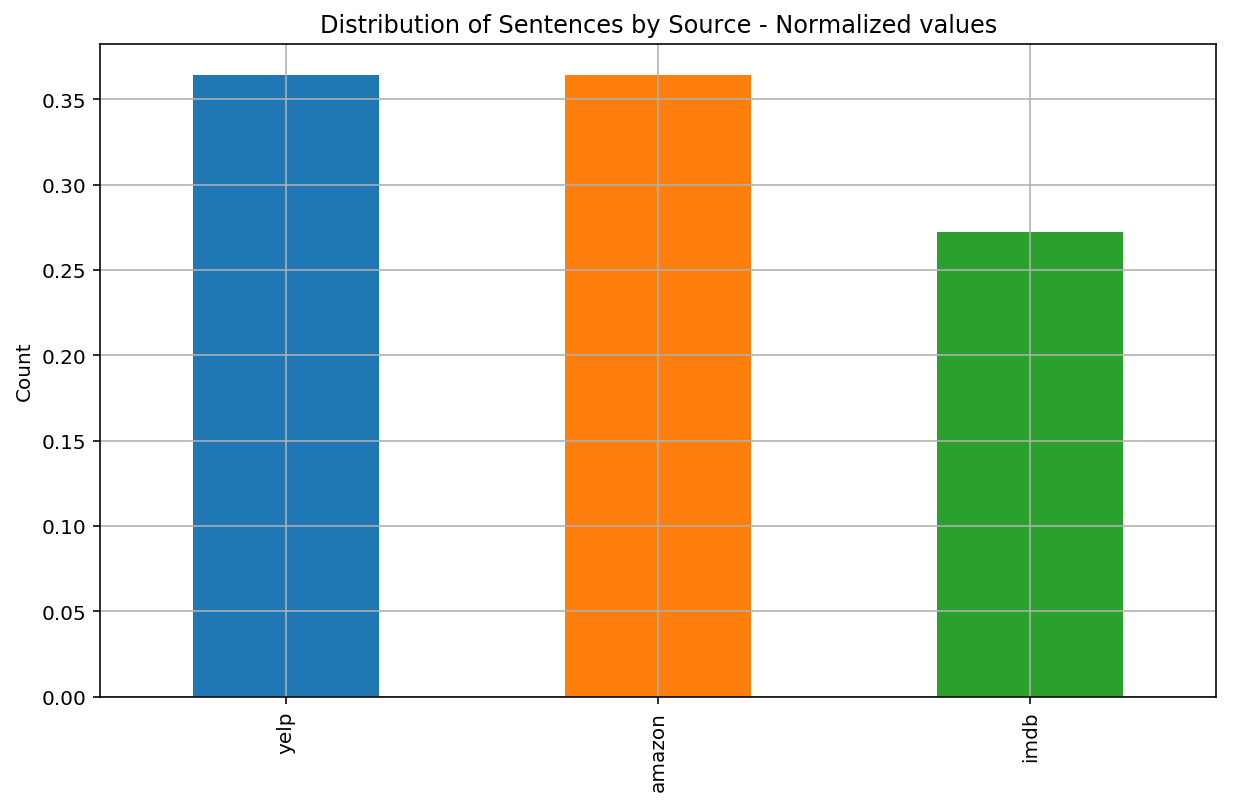

In [11]:
df.source.value_counts(normalize=True).plot(kind='bar', grid=True, figsize=(10, 6))
plt.title("Distribution of Sentences by Source - Normalized values")
plt.ylabel('Count')

**imdb** has less sentences than **yelp** and **amazon**

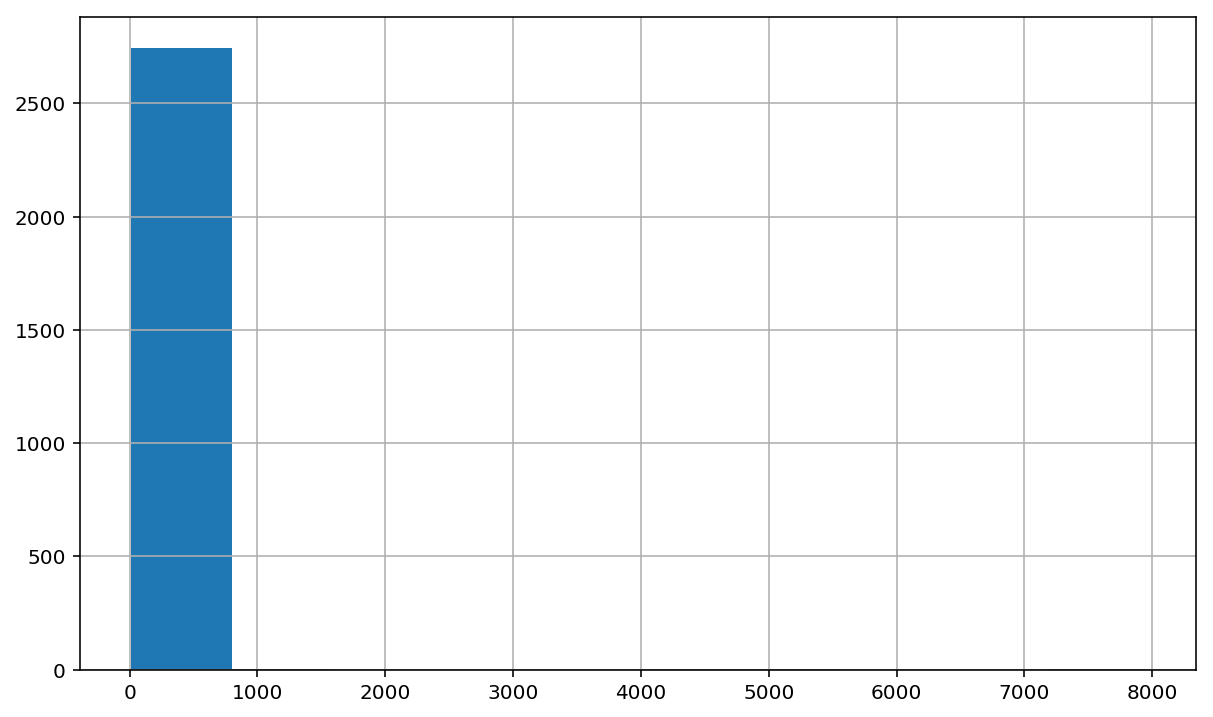

In [12]:
df.sentence.map(len).hist(figsize=(10, 6))

In [13]:
min(df.sentence.map(len))

7

In [14]:
max(df.sentence.map(len))

7944

How balanced are the labels?

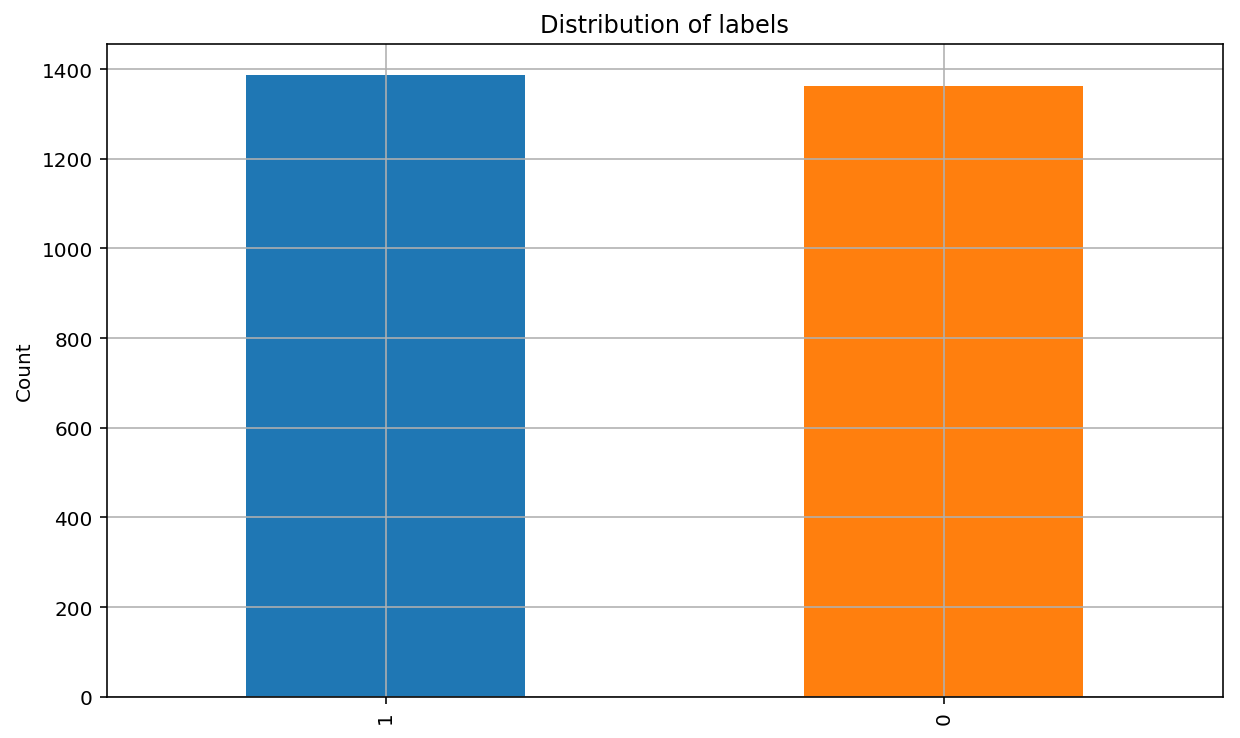

In [15]:
df.label.value_counts().plot(kind='bar', grid=True, figsize=(10, 6))
plt.title("Distribution of labels")
plt.ylabel('Count')

Sentence size range from 7 to 7944 characters.

### 3.1 NLP

Now I will tokenize and lemmatize the sentences.
    
Tokenization separates the sentences into a set of tokens.

Lemmatization aims at reducing the inflectional forms of each word into a common base or root. Lemmatization, on the other hand, takes into consideration the morphological analysis of the words.

I still need to better understand about the stop words removal in the contaxt of Text Classification. I do believe (for now) that we should not remove the negative words at least. Some discussion [here](https://datascience.stackexchange.com/questions/31048/pros-cons-of-stop-word-removal), [here](https://www.researchgate.net/post/Does_Pre-processing_step_Remove_Stop_Word_effect_Sentiment_Analysis_result) and [here](https://stackoverflow.com/questions/40144473/do-we-need-to-use-stopwords-filtering-before-pos-tagging)

In [16]:
tqdm.pandas()

In [17]:
df['tokens'] = df['sentence'].progress_apply(lambda d: lemmatize_sent(d), df.sentence, [])
# df['tokens'] = df.sentence.progress_apply(lambda d: lemmatize_sent(d), [i for i in df.sentence.values], [])
# flatten = lambda data: reduce(lambda x, y: x + y, data, [])

100%|██████████| 2748/2748 [00:05<00:00, 522.10it/s]


In [18]:
df['tokens'][:3]

0              [wow, love, place]
1              [crust, not, good]
2    [not, tasty, texture, nasty]
Name: tokens, dtype: object

In [19]:
sum(df['sentence'].isnull())

0

In [20]:
df.head()

,sentence,label,source,tokens
0,Wow... Loved this place.,1,yelp,"[wow, love, place]"
1,Crust is not good.,0,yelp,"[crust, not, good]"
2,Not tasty and the texture was just nasty.,0,yelp,"[not, tasty, texture, nasty]"
3,Stopped by during the late May bank holiday of...,1,yelp,"[stop, late, may, bank, holiday, rick, steve, ..."
4,The selection on the menu was great and so wer...,1,yelp,"[selection, menu, great, price]"


Checking the tokenization for the first 5 reviews (just to make sure it/how it worked):

In [21]:
for text, tokens in zip(df['sentence'].head(5), df['tokens'].head(5)):
    print('Description: ', text[:60])
    print('Tokens: ', tokens[:45])
    print('-----------------')

Description:  Wow... Loved this place.
Tokens:  ['wow', 'love', 'place']
-----------------
Description:  Crust is not good.
Tokens:  ['crust', 'not', 'good']
-----------------
Description:  Not tasty and the texture was just nasty.
Tokens:  ['not', 'tasty', 'texture', 'nasty']
-----------------
Description:  Stopped by during the late May bank holiday off Rick Steve r
Tokens:  ['stop', 'late', 'may', 'bank', 'holiday', 'rick', 'steve', 'recommendation', 'love']
-----------------
Description:  The selection on the menu was great and so were the prices.
Tokens:  ['selection', 'menu', 'great', 'price']
-----------------


What are the most frequent tokens:

In [22]:
alltokens = []
for token_list in df['tokens']:
    alltokens += token_list
counter = Counter(alltokens)

In [23]:
counter.most_common(5)

[('not', 591), ('good', 250), ('great', 215), ('movie', 212), ('film', 188)]

In [24]:
counter.most_common(10)

[('not', 591),
 ('good', 250),
 ('great', 215),
 ('movie', 212),
 ('film', 188),
 ('phone', 178),
 ('one', 149),
 ('work', 145),
 ('like', 140),
 ('bad', 139)]

Least frequent tokens:

In [25]:
counter.most_common()[-10:-1]

[('hollander', 1),
 ('flow', 1),
 ('hoot', 1),
 ('n', 1),
 ('bored', 1),
 ('jessice', 1),
 ('clothes', 1),
 ('virtue', 1),
 ('regrettable', 1)]

Finally, the weight of more common words which occur in all documents can be reduced. This is called *TFIDF* i.e Term Frequency times inverse document frequency. Now (as shown below) each of 2748 reviews is represented by 813 features, representing the tf-idf score for different ngrams.

min_df is set to 5, meaning that the word must be present in at least 5 documents to be kept

norm is set to l2

In [26]:
tfidf = TfidfVectorizer(
    sublinear_tf=True,
    min_df=5,
    norm='l2',
    encoding='latin-1',
    ngram_range=(1, 4))
features = tfidf.fit_transform(
    list(df['tokens'].map(lambda tokens: ' '.join(tokens))))
labels = df['label']
features.shape

(2748, 814)

In [27]:
tfidf_ = dict(zip(tfidf.get_feature_names(), tfidf.idf_))
tfidf_ = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf_), orient = 'index')
tfidf_.columns = ['tfidf']

In [28]:
tfidf_.sort_values(by = ['tfidf'], ascending = False)[:10]

,tfidf
ability,7.127233
issue,7.127233
good thing,7.127233
great deal,7.127233
green,7.127233
gross,7.127233
handle,7.127233
hat,7.127233
hole,7.127233
ice,7.127233


In [29]:
tfidf_.sort_values(by = ['tfidf'], ascending = True)[:10]

,tfidf
not,2.714435
good,3.489647
great,3.640878
phone,3.795029
movie,3.921780
film,3.970233
work,3.999012
time,4.066962
go,4.090679
like,4.098711


Distribution of the TFIDF score (inludes up to 5 grams):

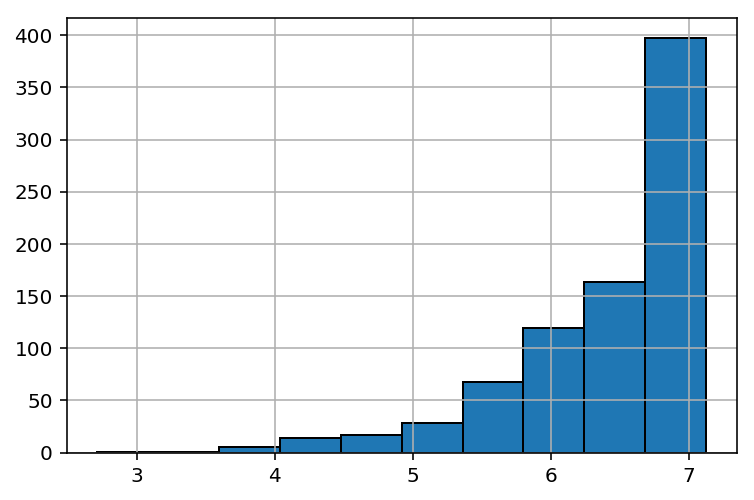

In [30]:
tfidf_.tfidf.hist(ec = 'black')

In [31]:
tfidf1 = TfidfVectorizer(
    sublinear_tf=True,
    min_df=5,
    norm='l2',
    encoding='latin-1',
    ngram_range=(1, 1))
features = tfidf1.fit_transform(
    list(df['tokens'].map(lambda tokens: ' '.join(tokens))))
labels = df['label']
features.shape

(2748, 701)

In [32]:
tfidf_1 = dict(zip(tfidf1.get_feature_names(), tfidf1.idf_))
tfidf_1 = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf_1), orient = 'index')
tfidf_1.columns = ['tfidf']

Tokens with lowest TFIDF score:

In [33]:
# tfidf_1.sort_values(by = ['tfidf'], ascending = True)[:10]

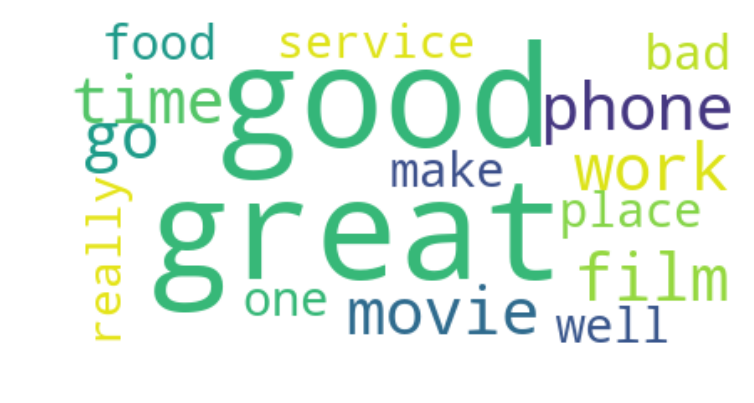

In [34]:
plot_wc(tfidf_1.sort_values(by = ['tfidf'], ascending = True)[:20], 
        './wc_lowest_tfidf.png')

Tokens with highest TFIDF score:

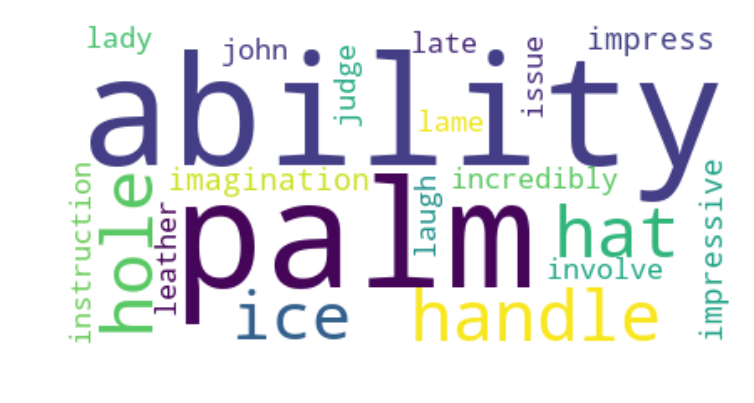

In [35]:
plot_wc(tfidf_1.sort_values(by = ['tfidf'], ascending = False).head(20), 
        './wc_highest_tfidf.png')

## 4. Modelling

In [194]:
X_train, X_test, y_train, y_test = train_test_split(
    df['tokens'],
    df['label'].values,
    random_state=24,
    shuffle=False,
    stratify=None,
    train_size=.8)
y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [ ]:
tfidf = TfidfVectorizer(
    sublinear_tf=True,
    min_df=5,
    norm='l2',
    encoding='latin-1',
    ngram_range=(1, 4))
features = tfidf.fit_transform(
    list(df['tokens'].map(lambda tokens: ' '.join(tokens))))
labels = df['label']
features.shape

### 4.1 Baseline model 
Model selection prior to using Keras

In [37]:
# custom_vec = CountVectorizer(tokenizer=lemmatize_sent)
# cwm = custom_vec.fit_transform(df['sentence'])
# tokens = custom_vec.get_feature_names()
# # wm2df(cwm, tokens)


In [38]:
results = pipeline_nlp(X_train, y_train, scoring='accuracy', n_folds=5)

Finished appending
[]
Checking models
KFold: SGD
cv
SGD: 0.812108 (+/- 0.020641)
KFold: XGB
cv
XGB: 0.761161 (+/- 0.030671)
KFold: LinearSVC
cv
LinearSVC: 0.825761 (+/- 0.017091)
KFold: AdaBoost
cv
AdaBoost: 0.756141 (+/- 0.025432)
KFold: GradientTreeBoost
cv
GradientTreeBoost: 0.770694 (+/- 0.025475)
All done


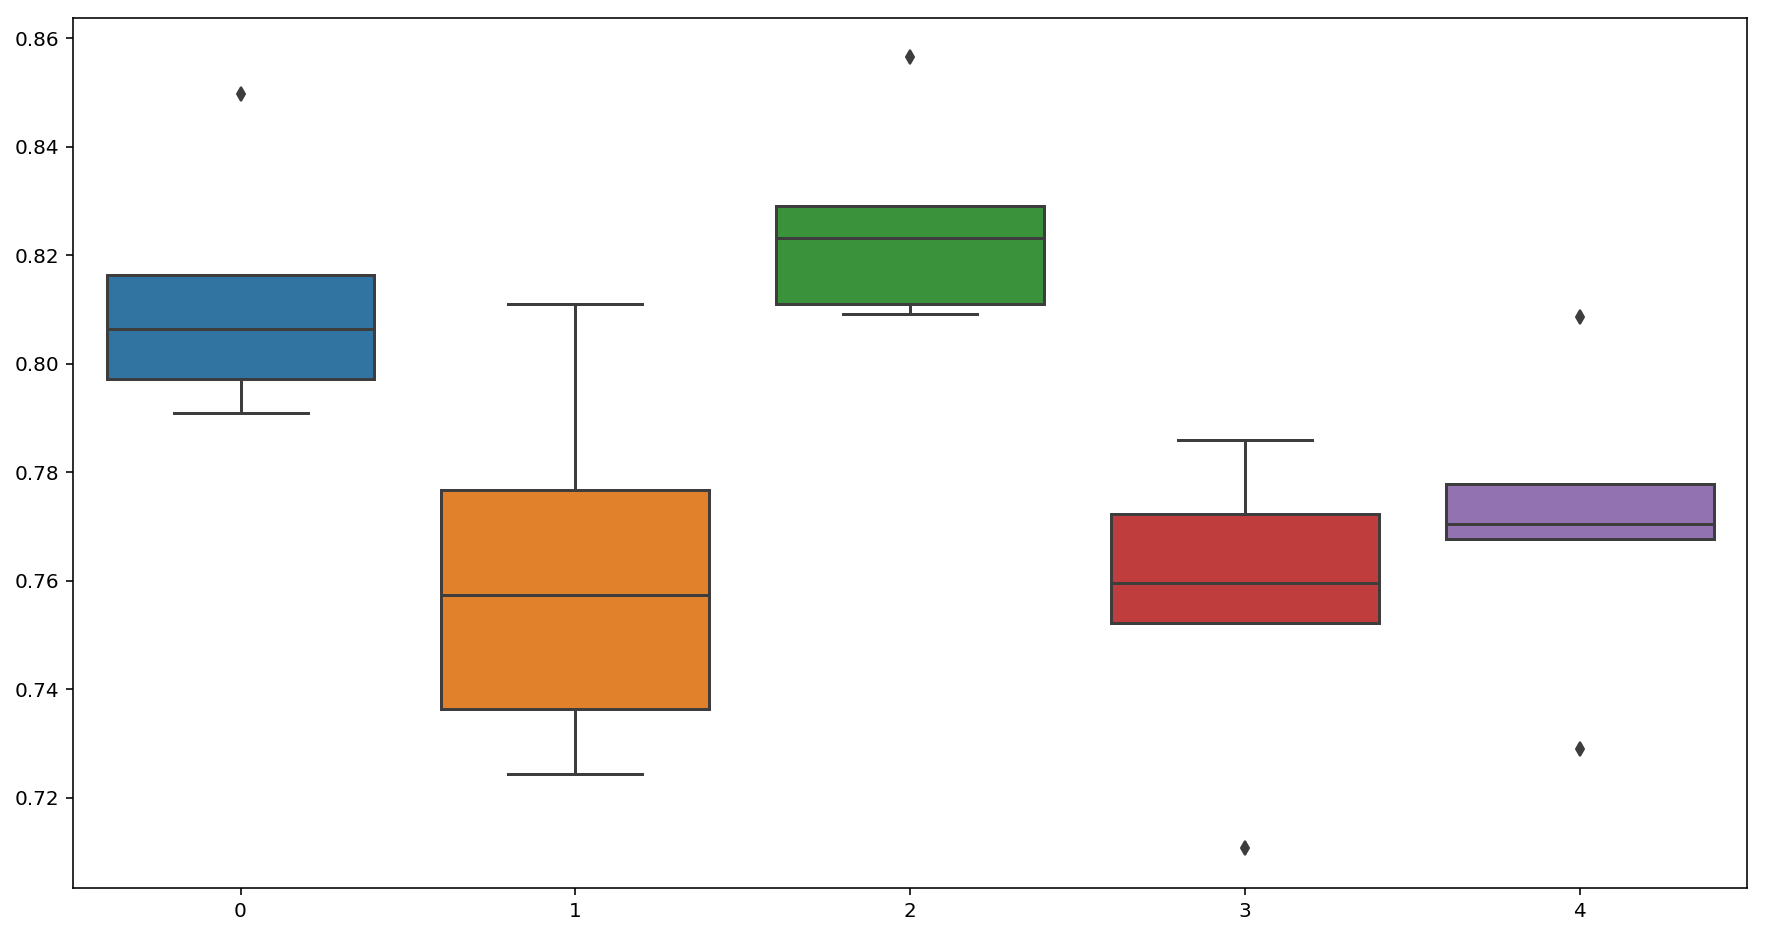

In [39]:
plt.figure(figsize=(15,8))
sns.boxplot(data=results)

LinearSVC has an average accuracy of over 0.8

How would the models perform for each source:

Finished appending
[]
Checking models
KFold: SGD
cv
SGD: 0.812108 (+/- 0.020641)
KFold: XGB
cv
XGB: 0.761161 (+/- 0.030671)
KFold: LinearSVC
cv
LinearSVC: 0.825761 (+/- 0.017091)
KFold: AdaBoost
cv
AdaBoost: 0.756141 (+/- 0.025432)
KFold: GradientTreeBoost
cv
GradientTreeBoost: 0.770694 (+/- 0.025475)
All done
Finished appending
[]
Checking models
KFold: SGD
cv
SGD: 0.812108 (+/- 0.020641)
KFold: XGB
cv
XGB: 0.761161 (+/- 0.030671)
KFold: LinearSVC
cv
LinearSVC: 0.825761 (+/- 0.017091)
KFold: AdaBoost
cv
AdaBoost: 0.756141 (+/- 0.025432)
KFold: GradientTreeBoost
cv
GradientTreeBoost: 0.770694 (+/- 0.025475)
All done
Finished appending
[]
Checking models
KFold: SGD
cv
SGD: 0.812108 (+/- 0.020641)
KFold: XGB
cv
XGB: 0.761161 (+/- 0.030671)
KFold: LinearSVC
cv
LinearSVC: 0.825761 (+/- 0.017091)
KFold: AdaBoost
cv
AdaBoost: 0.756141 (+/- 0.025432)
KFold: GradientTreeBoost
cv
GradientTreeBoost: 0.770694 (+/- 0.025475)
All done


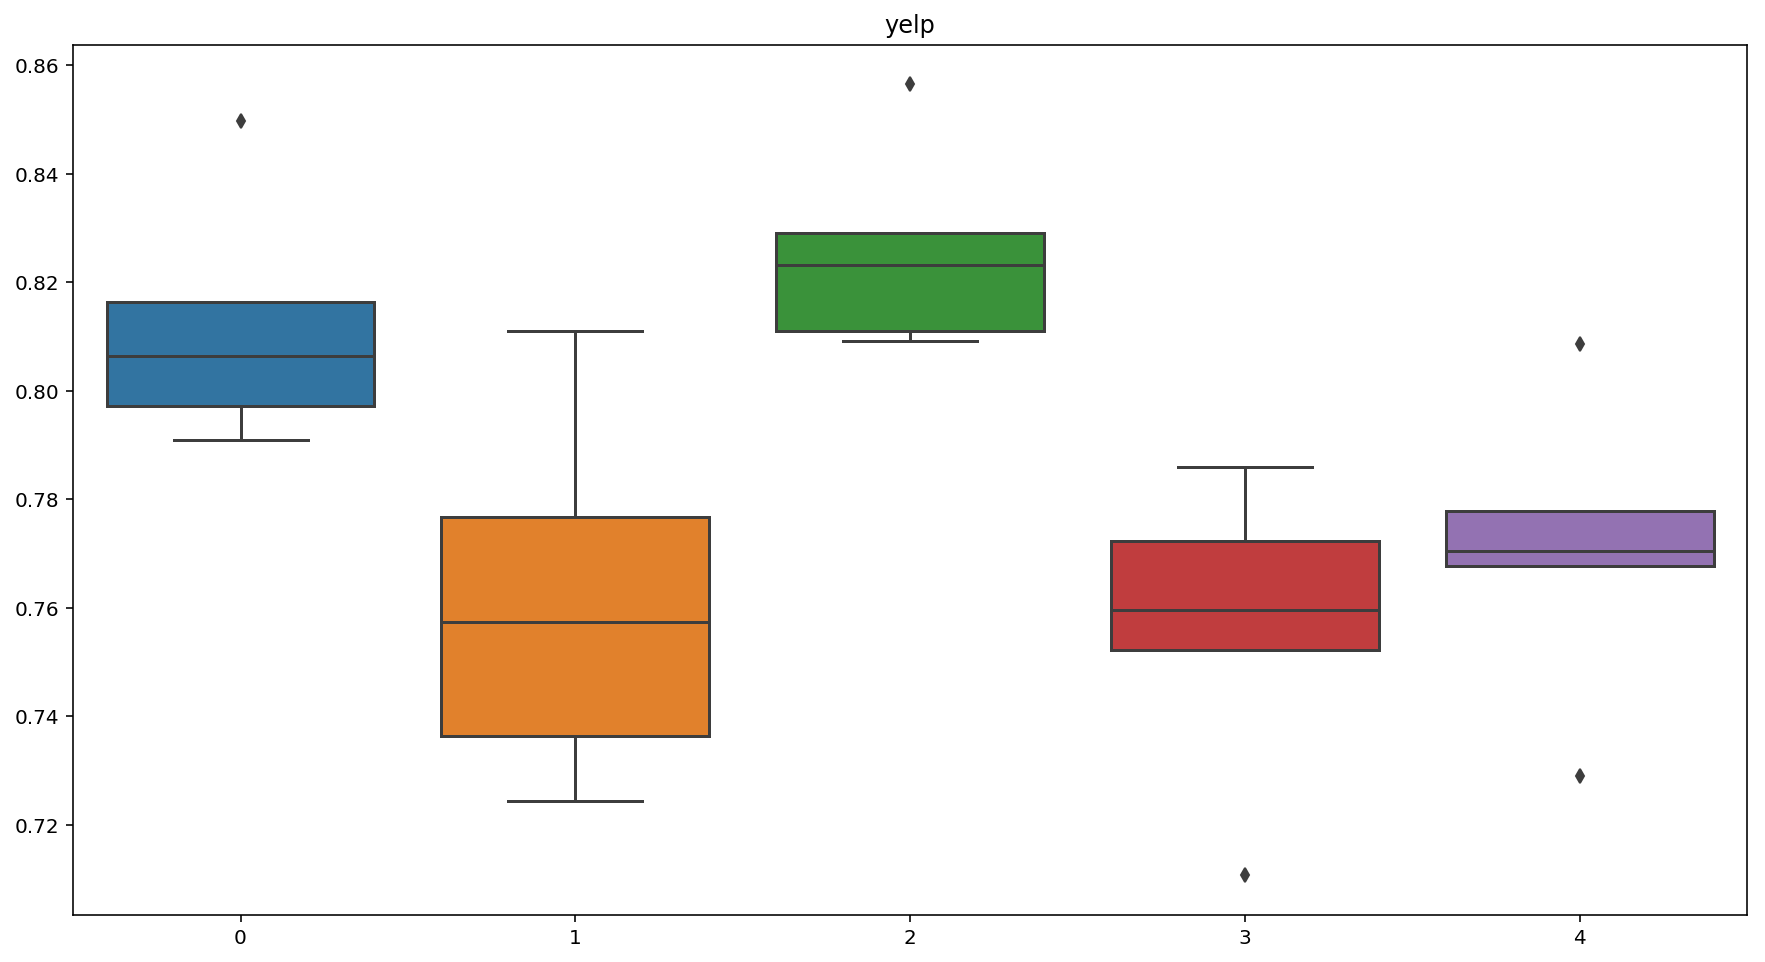

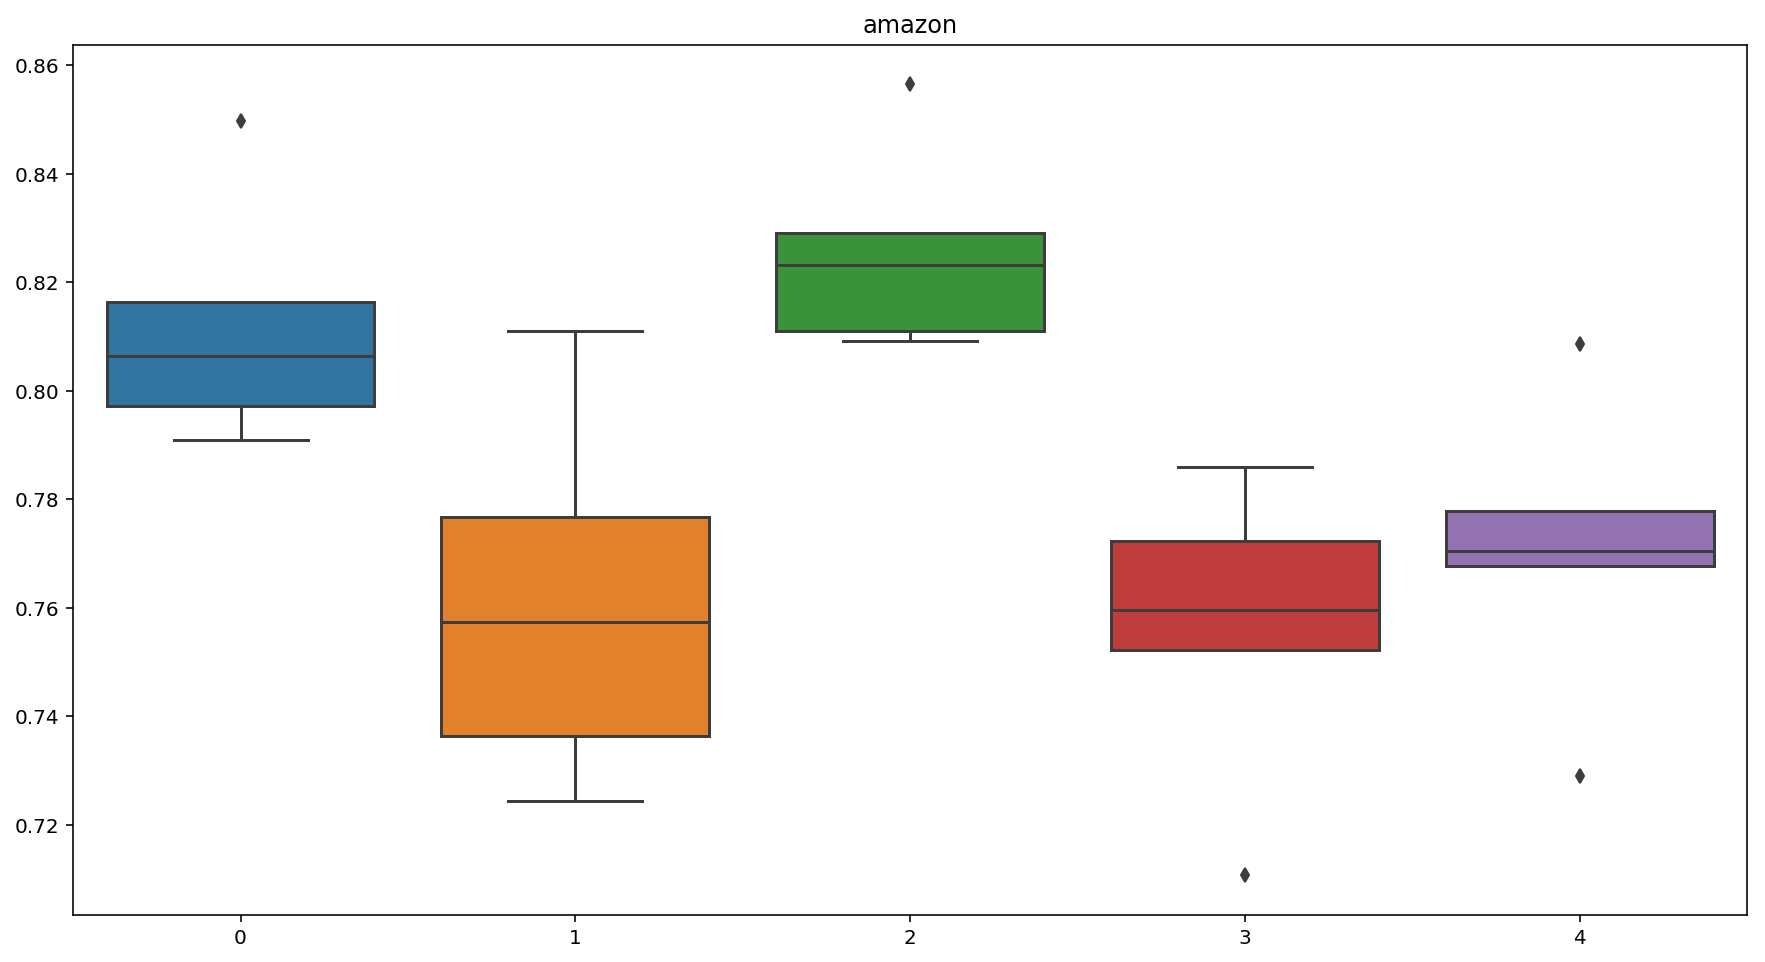

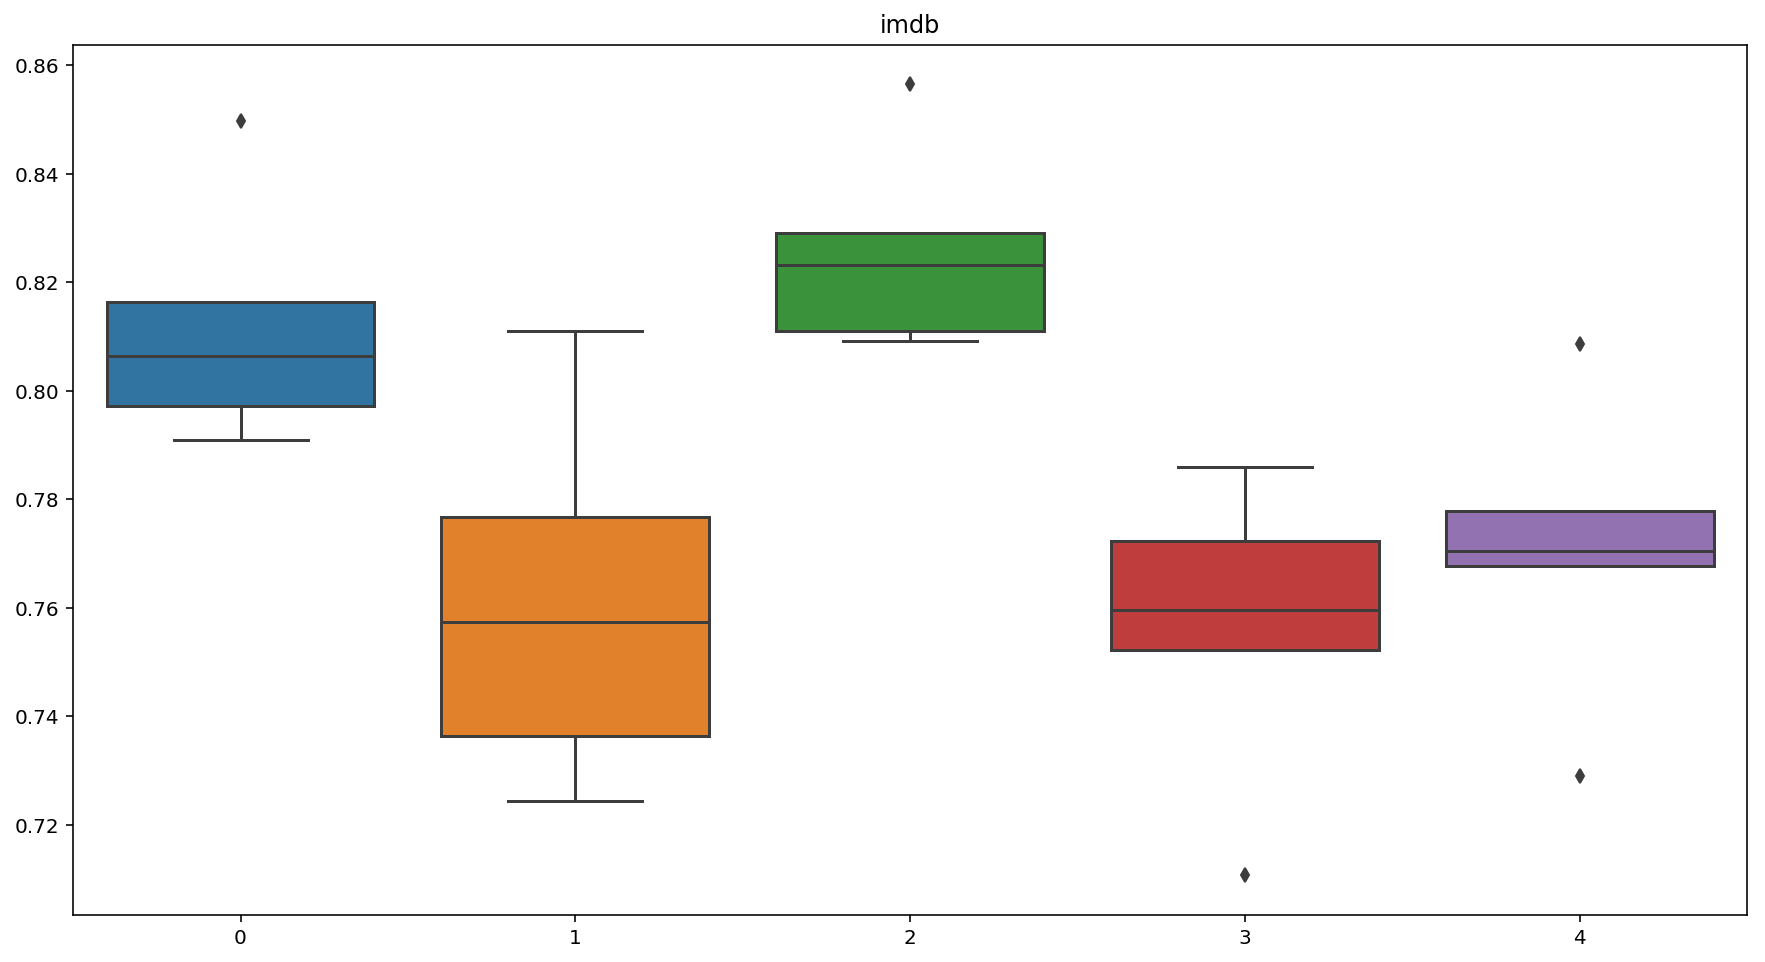

In [40]:
dct = {}
for source in df['source'].unique():
    df_source = df[df['source'] == source]
    x = df_source['sentence'].values
    y = df_source['label'].values

    X_train_, X_test_, y_train_, y_test_ = train_test_split(
        x, y, train_size=.8, random_state=24)
    y_train = y_train.astype('int')
    y_test = y_test.astype('int')
    
    results = pipeline_nlp(X_train, y_train, scoring='accuracy', n_folds=5)
        
    plt.figure(figsize=(15,8))
    sns.boxplot(data=results).set_title(source)

LinearSVC performed better than the other 4 models.

### 4.2 Parameter Tuning of Baseline Model

In [59]:
run_gs = True
seed = 42

LinearSVC

pipeline = Pipeline(
    [('vect', CountVectorizer(analyzer=lemmatize_sent)),
     ('tfidf', TfidfTransformer()),
     ('clf',
      CalibratedClassifierCV(base_estimator=LinearSVC(random_state=seed)))])

print("done: pipeline")

if run_gs:

    # Set the grid parameters

    LinearSVC_grid = {
        'vect__ngram_range': [(1, 1), (1, 2),(1, 4)],
        'vect__max_features': (None, 500, 1000),
        'tfidf__use_idf': [True, False],
        'clf__base_estimator__loss': ['hinge', 'squared_hinge', 'perceptron'],
        'clf__base_estimator__penalty': ['l2', 'l1', None, 'elasticnet'],
        'clf__base_estimator__dual': [True, False]
    }

    print("StratifiedKFold")

    cross_validation = StratifiedKFold(n_splits=5)
    #     cross_validation = KFold(n_splits=5)

    print("done: classifier")

    grid_search = GridSearchCV(
        pipeline,
        param_grid=LinearSVC_grid,
        cv=cross_validation,
        scoring="recall_weighted",
        error_score=0)

    print('Will fit now')

    grid_search.fit(X_train, y_train)

    model = grid_search

    parameters = grid_search.best_params_

    print('Best score: {}'.format(grid_search.best_score_))

    print('Best parameters: {}'.format(grid_search.best_params_))

    print('Best estimator: {}'.format(grid_search.best_estimator_))

else:

    parameters = {
        'vect__ngram_range': [(1, 1)],
        'vect__max_features': [None],
        'tfidf__use_idf': [True],
        'clf__base_estimator__loss': ['hinge'],
        'clf__base_estimator__penalty': ['l2']
    }

    model = LinearSVC(**parameters)

    model.fit(X_train, y_train)

done: pipeline
StratifiedKFold
done: classifier
Will fit now
Best score: 0.8321201091901729
Best parameters: {'clf__base_estimator__dual': True, 'clf__base_estimator__loss': 'hinge', 'clf__base_estimator__penalty': 'l2', 'tfidf__use_idf': True, 'vect__max_features': None, 'vect__ngram_range': (1, 1)}
Best estimator: Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=<function lemmatize_sent at 0x114559bf8>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=No...',
     penalty='l2', random_state=42, tol=0.0001, verbose=0),
            cv=3, method='sigmoid'))])


In [60]:
# pipeline.get_params().keys()

In [61]:
# save the model to disk
filename = 'LinearSVC_python3p6_CalibratedClassifierCV.dat'
pickle.dump(model, open(filename, 'wb'))

### 4.3 Evaluate predictions for Baseline Model

In [62]:
y_pred = model.predict(X_test)

Accuracy: 76.36%
             precision    recall  f1-score   support

          0       0.69      0.86      0.77       251
          1       0.86      0.68      0.76       299

avg / total       0.78      0.76      0.76       550

Confusion Matrix 
 [[217  34]
 [ 96 203]]


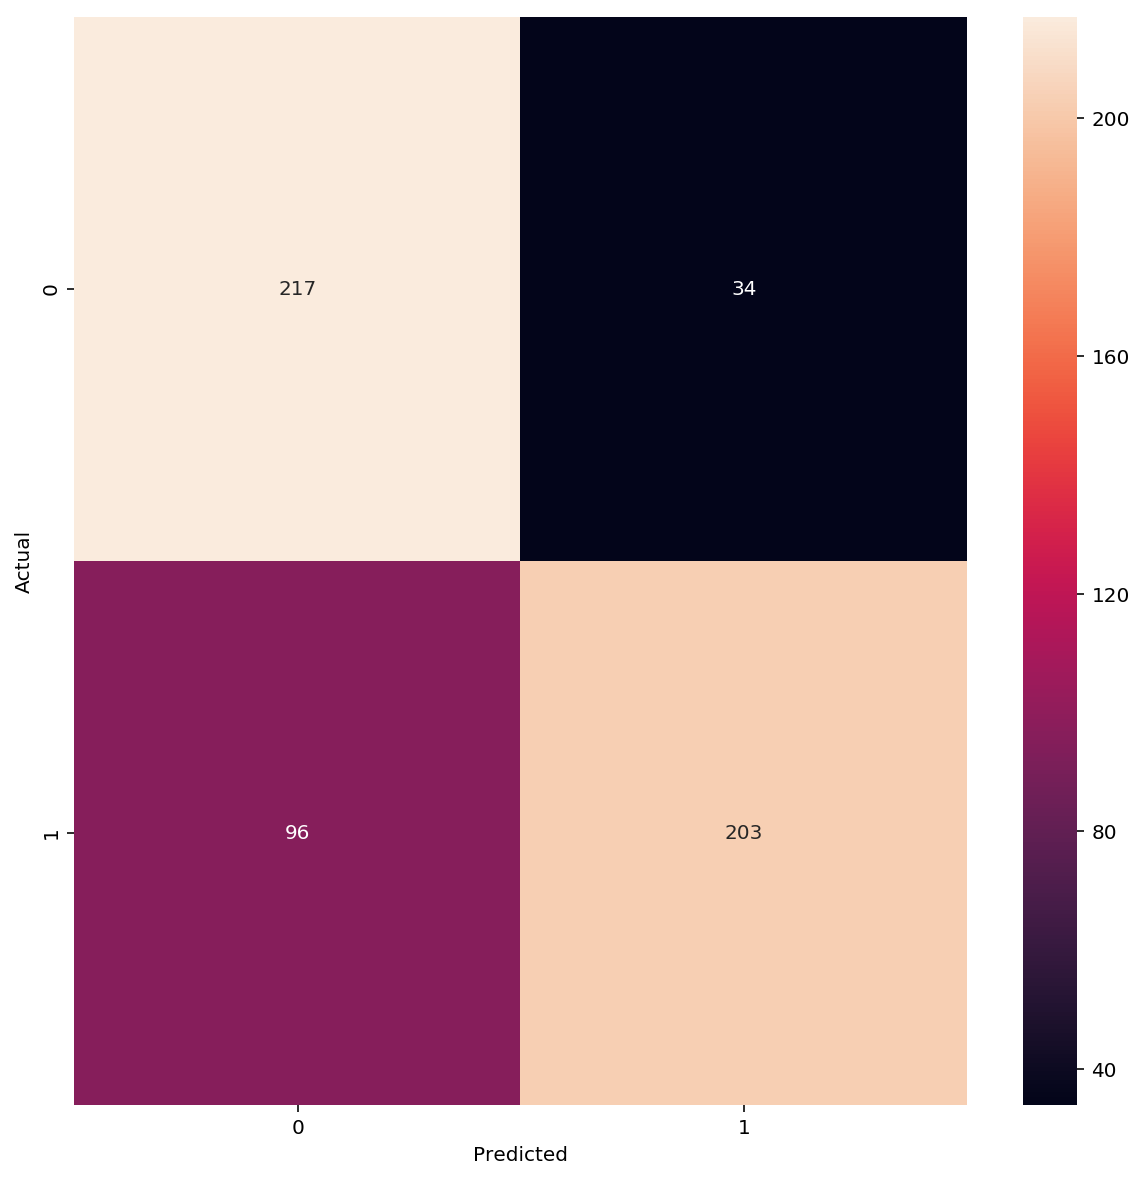

In [63]:
# evaluate predictions


# accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Classification report:
#label_list = sorted(list(y_test.unique()))
print (classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print ("Confusion Matrix \n", cm)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [64]:
pred_proba = model.predict_proba(X_test)
log_loss(y_test, pred_proba)

0.5198901861181864

In [65]:
pred_proba

array([[0.90488985, 0.09511015],
       [0.82294427, 0.17705573],
       [0.25264362, 0.74735638],
       ...,
       [0.55357225, 0.44642775],
       [0.99582387, 0.00417613],
       [0.9200327 , 0.0799673 ]])

### 4.4 Neural Network

In [66]:
from keras.models import Sequential
from keras import layers

In [217]:
from keras import backend as K
K.clear_session()

In [200]:
X_train, X_test, y_train, y_test = train_test_split(
    df['tokens'],
    df['label'].values,
    random_state=24,
    shuffle=False,
    stratify=None,
    train_size=.8)
y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [201]:
tfidf = TfidfVectorizer(
    sublinear_tf=True,
    min_df=5,
    norm='l2',
    encoding='latin-1',
    ngram_range=(1, 4))
features = tfidf.fit_transform(
    list(X_train.map(lambda tokens: ' '.join(tokens))))
labels = df['label']
features.shape

(2198, 619)

In [202]:
X_test  = tfidf.transform(list(X_test.map(lambda tokens: ' '.join(tokens))))

In [203]:
X_test.shape

(550, 619)

In [204]:
X_train = features

In [205]:
input_dim = X_train.shape[1]

In [206]:
X_train.shape

(2198, 619)

https://keras.io/getting-started/sequential-model-guide/

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense


In [218]:
model = Sequential()

In [219]:
model.add(layers.Dense(10, input_dim = input_dim, activation='relu'))

618 (input_dim) parameters, with 10 neurons in the first hidden layer (output)

In [220]:
model.add(layers.Dense(1, activation='sigmoid'))

In [221]:
# Start training - configuraton of the lerning process:

In [222]:
model.compile(
    loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [223]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                6200      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 6,211
Trainable params: 6,211
Non-trainable params: 0
_________________________________________________________________


*None* in the shape means it does not have a pre-defined number.

For *dense_1 layer* the number os parameters is 6200. This value is obtained as: 

In [215]:
(input_dim + 1) * 10 

6200

That means that for every hidden unit I have 618 (input_dim) input values + 1 bias times 10 neurons in the first layer

For *dense_2* I have 10 input values * 1 neuron in the layer + 1 bias 

In [180]:
10 + 1 * 1

11

In [181]:
# training with the .fit() function

It's necessary to specify the number of iterations. The completed iterations are called epochs. 

Batch size = how many sample in one forward/backward pass

In [224]:
md = model.fit(
    X_train,
    y_train,
    epochs=100,
    verbose=False,
    validation_data=(X_test, y_test))

In [216]:
md

Use the .evaluate() method to measure the accuracy of the model.

In [227]:
loss, accuracy = model.evaluate(X_train, y_train, verbose = False)

In [230]:
print("Training accuracy: {:.4f}".format(accuracy))

Training accuracy: 0.9604


In [231]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing accuracy:  {:.4f}".format(accuracy))

Testing accuracy:  0.7273


The model is overfitting  - it nearly reached 100% accuracy for the training set. The testing accuracy is not higher than the baseline model.

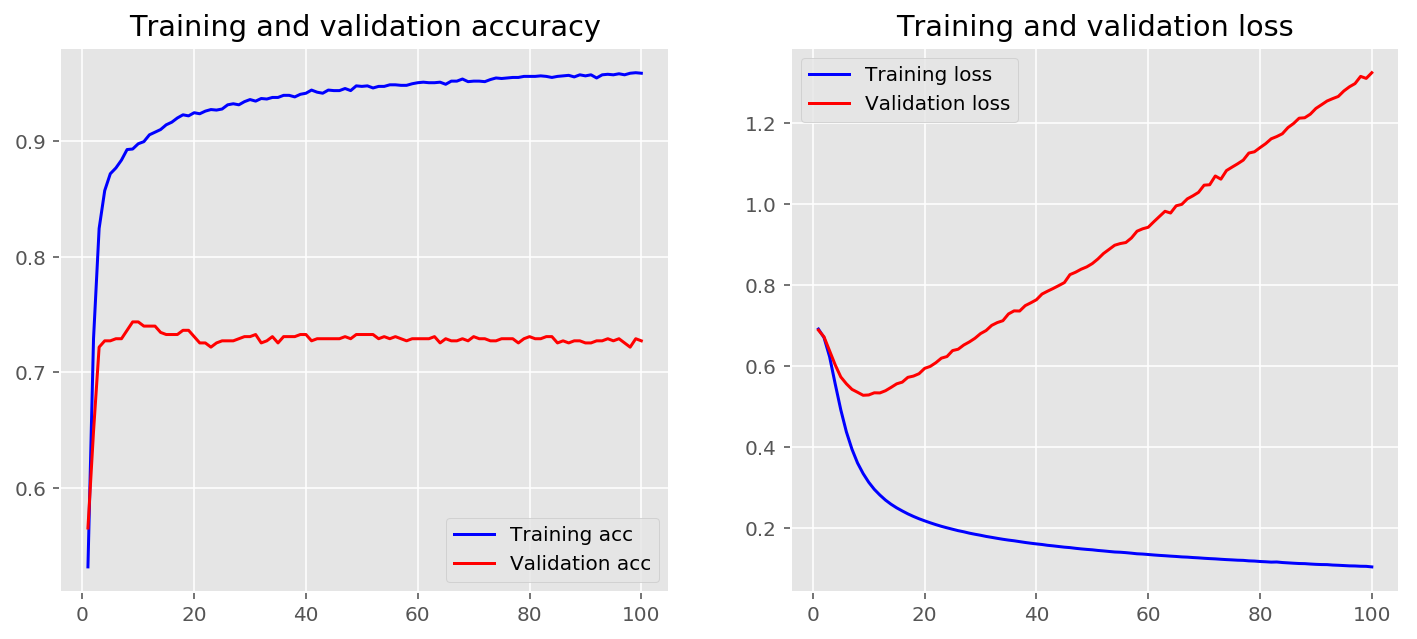

In [235]:
plot_history(md)

It's clear that the model was training for too long.  As it's shown above, the loss of the validation rises again, which indicates overfitting. This happens at around 15 epochs.

Also it's important to note that when training neural networks, one should use a separate testing and validation set. In this case, our testing and validation set are the same, since we have a smaller sample size. 